In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
SEED = 947
torch_utils.seed_everything(SEED)

In [3]:
from torchtext import data, datasets

In [4]:
TEXT = data.Field(tokenize="spacy", batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

In [5]:
%%time
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

CPU times: user 1min 31s, sys: 1.74 s, total: 1min 33s
Wall time: 2min 38s


In [9]:
train_data, valid_data = train_data.split(split_ratio=0.8, stratified=True, random_state=random.seed(SEED))

In [11]:
MAX_VOCAB_SIZE = 30000
TEXT.build_vocab(
    train_data,
    max_size=MAX_VOCAB_SIZE,
    vectors="glove.6B.100d",
    unk_init=torch.Tensor.normal_
)
LABEL.build_vocab(train_data)

In [12]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    device=device
)

In [173]:
class SentimentalCNNv1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super(SentimentalCNNv1, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=pad_idx
        )
        self.conv_0 = nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_sizes[0], embedding_dim)
        )
        self.conv_1 = nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_sizes[1], embedding_dim)
        )
        self.conv_2 = nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_sizes[2], embedding_dim)
        )
        self.fc = nn.Linear(len(filter_sizes)* n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, txt):
        # batch X sentence_lenght
        embedded = self.embedding(txt)
        # batch X sentence_lengght X embedding dimension
        embedded = embedded.unsqueeze(dim=1)
        #batch X 1 X sent len X embed dim
        
        conv0 = F.leaky_relu(self.conv_0(embedded).squeeze(dim=3))
        conv1 = F.leaky_relu(self.conv_1(embedded).squeeze(dim=3))
        conv2 = F.leaky_relu(self.conv_2(embedded).squeeze(dim=3))
        # batch x n_filters x sent len - filter_size[n]+1
        
        
        pool0 = F.max_pool1d(conv0, conv0.shape[2]).squeeze(2)
        pool1 = F.max_pool1d(conv1, conv1.shape[2]).squeeze(2)
        pool2 = F.max_pool1d(conv2, conv2.shape[2]).squeeze(2)
        
        cat = torch.cat((pool0, pool1, pool2), dim=1)
        cat = self.dropout(cat)
        
        return self.fc(cat)

In [174]:
class SentimentalCNNv2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super(SentimentalCNNv2, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=pad_idx
        )
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=1, 
                out_channels=n_filters, 
                kernel_size=(fs, embedding_dim)
            ) for fs in filter_sizes])
        
        self.fc = nn.Linear(len(filter_sizes)* n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, txt):
        # batch X sentence_lenght
        embedded = self.embedding(txt)
        # batch X sentence_lengght X embedding dimension
        embedded = embedded.unsqueeze(dim=1)
        #batch X 1 X sent len X embed dim
        convs = [F.leaky_relu(conv(embedded).squeeze(dim=3)) for conv in self.convs]
        # batch x n_filters x sent len - filter_size[n]+1
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(dim=2) for conv in convs]
        
        cat = torch.cat((pooled), dim=1)
        dropped = self.dropout(cat)
        
        return self.fc(dropped)

In [175]:
class SentimentalCNNv3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super(SentimentalCNNv3, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=pad_idx
        )
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim, 
                out_channels=n_filters, 
                kernel_size=fs
            ) for fs in filter_sizes])
        
        self.fc = nn.Linear(len(filter_sizes)* n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, txt):
        # batch X sentence_lenght
        embedded = self.embedding(txt)
        # batch X sentence_lengght X embedding dimension
        embedded = embedded.permute(0,2,1)
        #batch X embed dim X sent len 
        convs = [F.leaky_relu(conv(embedded)) for conv in self.convs]
        # batch x n_filters x sent len - filter_size[n]+1
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(dim=2) for conv in convs]
        
        cat = torch.cat((pooled), dim=1)
        dropped = self.dropout(cat)
        
        return self.fc(dropped)

In [184]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]


model2d = SentimentalCNNv2(INPUT_DIM,EMBEDDING_DIM,N_FILTERS,FILTER_SIZES,OUTPUT_DIM,DROPOUT,PAD_IDX).to(device)
model1d = SentimentalCNNv3(INPUT_DIM,EMBEDDING_DIM,N_FILTERS,FILTER_SIZES,OUTPUT_DIM,DROPOUT,PAD_IDX).to(device)
torch_utils.clear_cuda()

In [185]:
pretrained_embeddings = TEXT.vocab.vectors
model1d.embedding.weight.data.copy_(pretrained_embeddings)
model2d.embedding.weight.data.copy_(pretrained_embeddings)

model1d.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model1d.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model2d.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model2d.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [186]:
optimizer1d = torch_utils.RAdam(model1d.parameters())
optimizer2d = torch_utils.RAdam(model2d.parameters())

criterion = nn.BCEWithLogitsLoss()

In [187]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds==y).float()
    return correct.sum()/len(correct)

In [188]:
def train(model1d, model2d, iterator, optimizer1d, optimizer2d, criterion):
    l1,l2,a1,a2 = 0,0,0,0
    model1d.train()
    model2d.train()
    
    for batch in tqdm(iterator):
        optimizer1d.zero_grad()
        optimizer2d.zero_grad()
        
        preds1d = model1d(batch.text).squeeze(dim=1)
        preds2d = model2d(batch.text).squeeze(dim=1)
        
        loss1d = criterion(preds1d, batch.label)
        loss2d = criterion(preds2d, batch.label)
        
        acc1d = binary_accuracy(preds1d, batch.label)
        acc2d = binary_accuracy(preds2d, batch.label)
        
        loss1d.backward()
        loss2d.backward()
        
        optimizer1d.step()
        optimizer2d.step()
        
        l1+=loss1d.item()
        l2+=loss2d.item()
        a1+=acc1d.item()
        a2+=acc2d.item()
    
    return l1/len(iterator), l2/len(iterator), a1/len(iterator), a2/len(iterator)

In [189]:
def evaluate(model1d, model2d, iterator, criterion):
    l1,l2,a1,a2 = 0,0,0,0
    model1d.eval()
    model2d.eval()
    
    with torch.no_grad():
        for batch in tqdm(iterator):
            preds1d = model1d(batch.text).squeeze(dim=1)
            preds2d = model2d(batch.text).squeeze(dim=1)

            loss1d = criterion(preds1d, batch.label)
            loss2d = criterion(preds2d, batch.label)

            acc1d = binary_accuracy(preds1d, batch.label)
            acc2d = binary_accuracy(preds2d, batch.label)

            l1+=loss1d.item()
            l2+=loss2d.item()
            a1+=acc1d.item()
            a2+=acc2d.item()
    
    return l1/len(iterator), l2/len(iterator), a1/len(iterator), a2/len(iterator)

In [190]:
N_EPOCHS = 30
best_valid_loss1d = float("inf")
best_valid_loss2d = float("inf")
history = pd.DataFrame()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer2d,patience=2, factor=0.5)
ea1 = torch_utils.EarlyStopping(patience=5, verbose=True)
ea2 = torch_utils.EarlyStopping(patience=5, verbose=True)
for e in range(N_EPOCHS):
    print("EPOCH {} LEARNING RATE: {}".format(e+1, torch_utils.get_lr(optimizer2d)))
    st = time.time()
    tl1d, tl2d, ta1d, ta2d = train(model1d, model2d, train_iterator, optimizer1d, optimizer2d, criterion)
    vl1d, vl2d, va1d, va2d = evaluate(model1d, model2d, valid_iterator, criterion)
    
    if vl1d<best_valid_loss1d:
        best_valid_loss1d = vl1d
        torch.save(model1d.state_dict(),"best_valid_1d.pt")
    if vl2d<best_valid_loss2d:
        best_valid_loss2d = vl2d
        torch.save(model2d.state_dict(),"best_valid_2d.pt")
    scheduler.step(vl2d)
    ea2(vl2d, model2d)
    ea1(vl1d, model1d)
    
    print("EPOCH {} TIME: {}".format(e+1, time.time()-st))
    print("Model {} TL: {:.5f} TA {:.5f}%".format(1, tl1d, 100.0*ta1d))
    print("Model {} VL: {:.5f} VA {:.5f}%".format(1, vl1d, 100.0*va1d))
    print("Model {} TL: {:.5f} TA {:.5f}%".format(2, tl2d, 100.0*ta2d))
    print("Model {} VL: {:.5f} VA {:.5f}%".format(2, vl2d, 100.0*va2d))
    
    history.loc[e, "train_loss_2d"] = tl2d
    history.loc[e, "valid_loss_2d"] = vl2d
    history.loc[e, "train_acc_2d"] = ta2d
    history.loc[e, "valid_acc_2d"] = va2d
    
    history.loc[e, "train_loss_1d"] = tl1d
    history.loc[e, "valid_loss_1d"] = vl1d
    history.loc[e, "train_acc_1d"] = ta1d
    history.loc[e, "valid_acc_1d"] = va1d
    
    if ea1.early_stop and ea2.early_stop:
        break

EPOCH 1 LEARNING RATE: 0.001



Found better solution (inf --> 0.645280).  Saving model ...
Found better solution (inf --> 0.643566).  Saving model ...
EPOCH 1 TIME: 26.2432279586792
Model 1 TL: 0.69924 TA 55.17173%
Model 1 VL: 0.64357 VA 65.52611%
Model 2 TL: 0.69812 TA 54.87720%
Model 2 VL: 0.64528 VA 64.61630%
EPOCH 2 LEARNING RATE: 0.001



Found better solution (0.645280 --> 0.510617).  Saving model ...
Found better solution (0.643566 --> 0.504348).  Saving model ...
EPOCH 2 TIME: 26.10103130340576
Model 1 TL: 0.60554 TA 67.14756%
Model 1 VL: 0.50435 VA 77.94699%
Model 2 TL: 0.60944 TA 66.95288%
Model 2 VL: 0.51062 VA 77.98655%
EPOCH 3 LEARNING RATE: 0.001



Found better solution (0.510617 --> 0.388722).  Saving model ...
Found better solution (0.504348 --> 0.388504).  Saving model ...
EPOCH 3 TIME: 25.671444177627563
Model 1 TL: 0.43254 TA 80.19669%
Model 1 VL: 0.38850 VA 83.04984%
Model 2 TL: 0.44066 TA 79.68251%
Model 2 VL: 0.38872 VA 82.93117%
EPOCH 4 LEARNING RATE: 0.001



Found better solution (0.388722 --> 0.344086).  Saving model ...
Found better solution (0.388504 --> 0.342470).  Saving model ...
EPOCH 4 TIME: 25.615960359573364
Model 1 TL: 0.34554 TA 85.02396%
Model 1 VL: 0.34247 VA 85.54193%
Model 2 TL: 0.33799 TA 85.55811%
Model 2 VL: 0.34409 VA 85.68038%
EPOCH 5 LEARNING RATE: 0.001



Found better solution (0.344086 --> 0.324777).  Saving model ...
Found better solution (0.342470 --> 0.332209).  Saving model ...
EPOCH 5 TIME: 25.46008586883545
Model 1 TL: 0.26575 TA 89.19728%
Model 1 VL: 0.33221 VA 85.87816%
Model 2 TL: 0.26368 TA 88.93770%
Model 2 VL: 0.32478 VA 86.27373%
EPOCH 6 LEARNING RATE: 0.001



Found better solution (0.324777 --> 0.323087).  Saving model ...
EarlyStopping counter: 1 out of 5
EPOCH 6 TIME: 24.44394874572754
Model 1 TL: 0.20531 TA 92.03275%
Model 1 VL: 0.33316 VA 86.01661%
Model 2 TL: 0.20669 TA 91.99281%
Model 2 VL: 0.32309 VA 86.51108%
EPOCH 7 LEARNING RATE: 0.001



EarlyStopping counter: 1 out of 5
Found better solution (0.332209 --> 0.325300).  Saving model ...
EPOCH 7 TIME: 24.472310543060303
Model 1 TL: 0.15439 TA 94.12440%
Model 1 VL: 0.32530 VA 86.94620%
Model 2 TL: 0.14971 TA 94.54872%
Model 2 VL: 0.33427 VA 86.47152%
EPOCH 8 LEARNING RATE: 0.001



EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EPOCH 8 TIME: 24.78021240234375
Model 1 TL: 0.11534 TA 95.73682%
Model 1 VL: 0.35404 VA 86.31329%
Model 2 TL: 0.11208 TA 95.89657%
Model 2 VL: 0.35973 VA 86.60997%
EPOCH 9 LEARNING RATE: 0.001



EarlyStopping counter: 3 out of 5
EarlyStopping counter: 2 out of 5
EPOCH 9 TIME: 26.05106210708618
Model 1 TL: 0.08057 TA 97.42412%
Model 1 VL: 0.37177 VA 87.06487%
Model 2 TL: 0.07672 TA 97.51897%
Model 2 VL: 0.39406 VA 86.49130%
EPOCH 10 LEARNING RATE: 0.0005



EarlyStopping counter: 4 out of 5
EarlyStopping counter: 3 out of 5
EPOCH 10 TIME: 25.553879976272583
Model 1 TL: 0.06148 TA 98.05811%
Model 1 VL: 0.40401 VA 86.45174%
Model 2 TL: 0.05221 TA 98.48742%
Model 2 VL: 0.38753 VA 86.88687%
EPOCH 11 LEARNING RATE: 0.0005



EarlyStopping counter: 5 out of 5
EarlyStopping counter: 4 out of 5
EPOCH 11 TIME: 25.54375982284546
Model 1 TL: 0.04437 TA 98.63718%
Model 1 VL: 0.42803 VA 86.84731%
Model 2 TL: 0.03781 TA 98.98163%
Model 2 VL: 0.40557 VA 86.76820%
EPOCH 12 LEARNING RATE: 0.0005



EarlyStopping counter: 6 out of 5
EarlyStopping counter: 5 out of 5
EPOCH 12 TIME: 25.275324821472168
Model 1 TL: 0.03135 TA 99.09645%
Model 1 VL: 0.45543 VA 86.64953%
Model 2 TL: 0.02973 TA 99.26118%
Model 2 VL: 0.43038 VA 86.57041%


AttributeError: 'EarlyStopping' object has no attribute 'eary_stop'

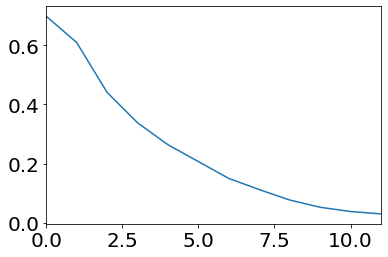

In [191]:
history["train_loss_2d"].plot()

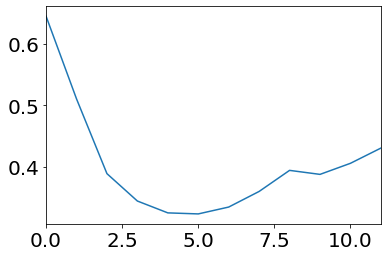

In [192]:
history["valid_loss_2d"].plot()

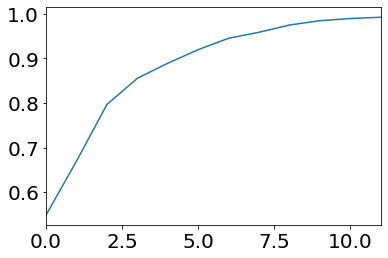

In [193]:
history["train_acc_2d"].plot()

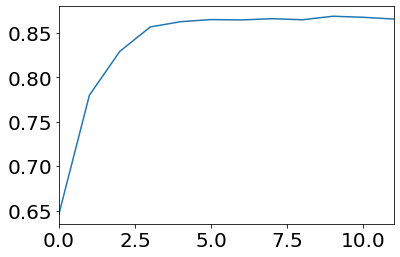

In [194]:
history["valid_acc_2d"].plot()

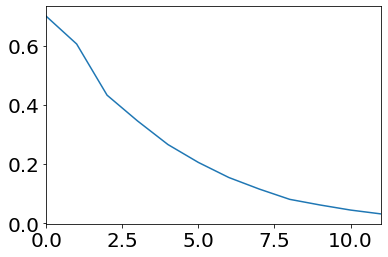

In [195]:
history["train_loss_1d"].plot()

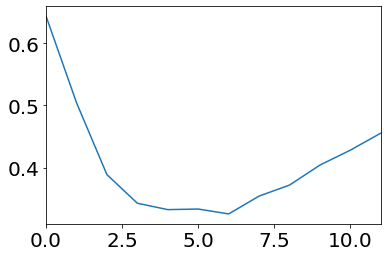

In [196]:
history["valid_loss_1d"].plot()

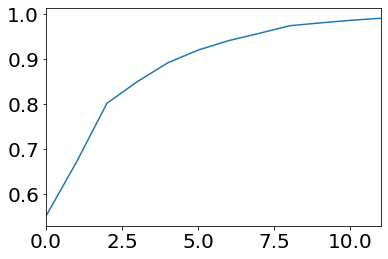

In [197]:
history["train_acc_1d"].plot()

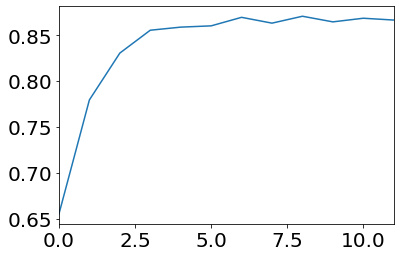

In [198]:
history["valid_acc_1d"].plot()

In [199]:
l1,l2,a1,a2 = evaluate(model1d, model2d, test_iterator, criterion)
print(l2, 100*a2)
print(l1, 100*a1)


0.47158506634595143 85.38043479175519
0.5178641037029379 85.04635549872123


In [200]:
model2d.load_state_dict(torch.load("best_valid_2d.pt", map_location=device))
model1d.load_state_dict(torch.load("best_valid_1d.pt", map_location=device))

<All keys matched successfully>

In [201]:
l1,l2,a1,a2 = evaluate(model1d, model2d, test_iterator, criterion)
print(l2, 100*a2)
print(l1, 100*a1)


0.34638526324954483 85.19661126234342
0.3472147248971188 86.038203327857


In [202]:
import spacy
nlp = spacy.load("en")

In [207]:
def predict_sentiment(model, txt, min_length = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(txt)]
    if len(tokenized)<min_length:
        tokenized+=["<pad>"]*(min_length-len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(dim=0)
    pred = torch.sigmoid(model(tensor))
    return pred.item()

In [214]:
print(predict_sentiment(model1d, "why would the director make such a greatly boring movie?"))
print(predict_sentiment(model2d, "why would the director make such a greatly boring movie?"))

0.015887578949332237
0.045606374740600586
